<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/adult_census/Prototype_Model/categorical_label_embedding_DNN_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

one-hotベクトルの次元数が増える場合はエンベディングするのがベストといわれてる：https://www.tensorflow.org/tutorials/structured_data/feature_columns
カテゴリ列はstring_int layerを前処理で、embeddinglayerをモデルに採用
カテゴリ列以外は、標準化レイヤーをモデルに採用

In [1]:
%pip show tensorflow scikit-learn

Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: h5py, opt-einsum, astunparse, six, numpy, protobuf, gast, absl-py, tensorflow-estimator, wrapt, tensorboard, keras-preprocessing, scipy, grpcio, wheel, termcolor, google-pasta
Required-by: fancyimpute
---
Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, scipy, joblib
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, imbalanced-learn, fancyimpute


[国税調査データセット:https://www.openml.org/d/1590](https://www.openml.org/d/1590)

In [2]:
import datetime, IPython, os 

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import Model, Input, layers, optimizers, callbacks
from tensorflow.keras.layers.experimental.preprocessing import Normalization,StringLookup
from tensorflow.keras.utils import plot_model

# データ読み込み

In [16]:
%%time
DATA_ID = '1590' #@param{type:'string'}

# データセットをフェッチ
result = fetch_openml(data_id=DATA_ID,
                    as_frame=True)
X = result.data
y = result.target
x_cols = result.feature_names
y_col = result.target_names

display(x_cols)
display(X.head())
display(y_col)
display(y.head())


def proc_y(y):
    '''ラベルの加工'''

    def _one_hot_encode(y):
        '''ワンホットエンコードしたnumpy.ndarrayを返す'''
        return pd.get_dummies(y)

    proc_y = _one_hot_encode(y=y)
    return proc_y


categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                    'relationship', 'race', 'sex', 'native-country']
numericla_cols =  set(X.columns) ^ set(categorical_cols)
y=proc_y(y=y)

display(X.head())
display(y.head())


SEED = 7 #@param{type:'number'}
SPLIT = 0.2 #@param{type:'number'}

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=SPLIT,
                                                    random_state=SEED,
                                                    shuffle=True)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=SPLIT,
                                                  random_state=SEED,
                                                  shuffle=True)

display('train shape:{}'.format(train_X.shape))
display('val shape:{}'.format(val_X.shape))
display('test shape:{}'.format(test_X.shape))


# モデルの入力形式に合わせて特徴量を辞書型で扱う
def create_dictionary(X_df, numericla_cols, categorical_cols):
    '''辞書型のオブジェクト作成'''
    obj = {}
    obj['numerical_X'] = X_df[numericla_cols].values
    for cate_col in categorical_cols:
        obj[cate_col] = X_df[cate_col]
    return obj


train_X = create_dictionary(X_df=train_X, numericla_cols=numericla_cols,
                            categorical_cols=categorical_cols)
val_X = create_dictionary(X_df=val_X, numericla_cols=numericla_cols,
                            categorical_cols=categorical_cols)
test_X = create_dictionary(X_df=test_X, numericla_cols=numericla_cols,
                            categorical_cols=categorical_cols)
#display(train_X)

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

age  workclass    fnlwgt  ... capital-loss  hours-per-week native-country
0  25.0    Private  226802.0  ...          0.0            40.0  United-States
1  38.0    Private   89814.0  ...          0.0            50.0  United-States
2  28.0  Local-gov  336951.0  ...          0.0            40.0  United-States
3  44.0    Private  160323.0  ...          0.0            40.0  United-States
4  18.0        NaN  103497.0  ...          0.0            30.0  United-States

[5 rows x 14 columns]

['class']

0    <=50K
1    <=50K
2     >50K
3     >50K
4    <=50K
Name: class, dtype: category
Categories (2, object): ['>50K', '<=50K']

age  workclass    fnlwgt  ... capital-loss  hours-per-week native-country
0  25.0    Private  226802.0  ...          0.0            40.0  United-States
1  38.0    Private   89814.0  ...          0.0            50.0  United-States
2  28.0  Local-gov  336951.0  ...          0.0            40.0  United-States
3  44.0    Private  160323.0  ...          0.0            40.0  United-States
4  18.0        NaN  103497.0  ...          0.0            30.0  United-States

[5 rows x 14 columns]

>50K  <=50K
0     0      1
1     0      1
2     1      0
3     1      0
4     0      1

'train shape:(31258, 14)'

'val shape:(7815, 14)'

'test shape:(9769, 14)'

CPU times: user 1.35 s, sys: 43.1 ms, total: 1.39 s
Wall time: 1.39 s


In [32]:
#train_X['education']
layer = StringLookup(vocabulary=list(train_X['education'].unique()))
layer

# モデル構築

In [33]:
%%time
def model_fn(train_X, num_class, embedding_dim, categorical_X_keys,
             numerical_X_key='numerical_X', dropout_seed=None):
    '''モデルの構造定義
    
    Parameters
    -----
    train_X : numpy.ndarray
      訓練データ
      INFO : 前処理レイヤーの適合に必要
    num_class : int
      分類するクラス数
    embedding_dim : int
      埋め込み後の次元数
    categorical_X_keys : list of string
      標準化レイヤーに適合させるカテゴリ変数型の特徴量が格納されているkey名配列
    numerical_X_key : string (default : numerical_X)
      標準化レイヤーに適合させる数値型の特徴量が格納されているkey名
    dropout_seed : float (default : None)
    '''

    def _setup_norm_layer(adapt_X):
        '''標準化レイヤーのセットアップ'''
        norm_layer = Normalization()
        norm_layer.adapt(adapt_X)
        return norm_layer


    # 数値データ用の入力層
    numerical_X = train_X[numerical_X_key]
    input_shape = numerical_X.shape[1]
    numerical_input = layers.Input(shape=input_shape,
                                   name=numerical_X_key)
    norm_layer = _setup_norm_layer(adapt_X=numerical_X)
    numerical_features = norm_layer(numerical_input)


    # カテゴリ変数用の入力レイヤー
    def _categorical_layers_fn(train_X, categorical_X_keys, emb_dim):
        
        def _categorical_layer_fn(feature_name, feature, emb_dim, shape=1):
            input_layer = layers.Input(shape=shape, name=feature_name+'_X')
            st_lookup_layer = StringLookup(vocabulary=list(feature.unique()))(input_layer)
            #print(st_lookup_layer)
            #todododo
            emb_layer = layers.Embedding(input_dim=shape, output_dim=emb_dim)(st_lookup_layer)
            return emb_layer

        categorical_layers = []
        for categori_key in categorical_X_keys:
            categori_layer = _categorical_layer_fn(feature_name=categori_key,
                                                   emb_dim=emb_dim,
                                                   feature=train_X[categori_key])
            categorical_layers.append(categori_layer)
    
        return categorical_layers


    categorical_layers = _categorical_layers_fn(train_X,
                                                emb_dim=embedding_dim,
                                                categorical_X_keys=categorical_X_keys)


    # 複数の入力層の結合を行うレイヤー
    concatenate_layers = categorical_layers.append(numerical_features)
    x = layers.concatenate(inputs=concatenate_layers)

    # データ解析レイヤー
    x = layers.Dense(units=256, activation='relu')(x)
    x = layers.Dropout(rate=0.3, seed=dropout_seed)(x)
    x = layers.Dense(units=128, activation='relu')(x)
    x = layers.Dropout(rate=0.3, seed=dropout_seed)(x)

    # 出力レイヤー
    output = layers.Dense(units=num_class, activation='softmax')(x)

    model = Model(inputs=[numerical_input, one_hot_input],
                  outputs=output)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model


num_class = train_y.shape[1]
embedding_dim = 8

classifier = model_fn(train_X=train_X,
                      num_class=num_class,
                      embedding_dim=embedding_dim,
                      categorical_X_keys=categorical_cols,
                      numerical_X_key='numerical_X',
                      dropout_seed=SEED)
display(classifier)
display(plot_model(classifier))

47757             Private
30229             Private
25394         Federal-gov
5831              Private
34379         Federal-gov
               ...       
36230             Private
17922             Private
14451           State-gov
32438             Private
8061     Self-emp-not-inc
Name: workclass, Length: 31258, dtype: category
Categories (8, object): ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov',
                         'Local-gov', 'State-gov', 'Without-pay', 'Never-worked']


ValueError: ignored

In [ ]:
# 各モデルのepoch数
EPOCH =  100#@param{type:'number'}
BATCH_SIZE = 1024#@param{type:'number'}

# 早期停止コールバックの定義
es = callbacks.EarlyStopping(monitor='val_loss',
                             patience=5)

In [ ]:
%%time
classifier.fit(x=train_X, y=train_y,
               epochs=EPOCH,
                batch_size=BATCH_SIZE,
                validation_data=(val_X, val_y),
                callbacks=[es])

Epoch 1/100
31/31 [==============================] - 1s 21ms/step - loss: 3666.6011 - accuracy: 0.6459 - val_loss: 507.4944 - val_accuracy: 0.7766
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 747.1047 - accuracy: 0.6534 - val_loss: 15.3300 - val_accuracy: 0.7715
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 105.0070 - accuracy: 0.6436 - val_loss: 0.7001 - val_accuracy: 0.7602
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 22.4453 - accuracy: 0.6911 - val_loss: 0.6683 - val_accuracy: 0.7612
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 9.2588 - accuracy: 0.7323 - val_loss: 0.6493 - val_accuracy: 0.7596
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 6.1961 - accuracy: 0.7454 - val_loss: 0.6326 - val_accuracy: 0.7596
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 4.3393 - accuracy: 0.7507 - val_loss: 0.6193 - val_accuracy: 0.

# ベストなモデルの可視化

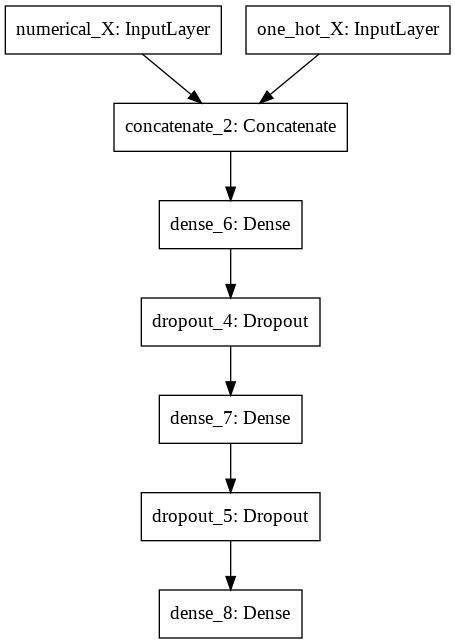

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
numerical_X (InputLayer)        [(None, 6)]          0                                            
__________________________________________________________________________________________________
one_hot_X (InputLayer)          [(None, 91)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 97)           0           numerical_X[0][0]                
                                                                 one_hot_X[0][0]                  
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          25088       concatenate_2[0][0]   

None

In [ ]:
def displaymodel(model):
    '''モデルの構造を表示'''
    display(plot_model(model))
    display(model.summary())


displaymodel(model=classifier)

# モデルの評価

## Kerasの組み込み評価関数

In [ ]:
%%time
score = classifier.evaluate(x=test_X, y=test_y, batch_size=BATCH_SIZE)
display('loss : {}, accuracy : {}'.format(score[0], score[1]))

10/10 [==============================] - 0s 4ms/step - loss: 0.5418 - accuracy: 0.7671


'loss : 0.541772186756134, accuracy : 0.7671204805374146'

CPU times: user 113 ms, sys: 13.2 ms, total: 126 ms
Wall time: 114 ms


## sklearnの評価関数

In [ ]:
%%time
def predict_classes(model, x):
    '''ラスラベルの予測を取得'''
    return np.argmax(model.predict(x), axis=-1)


# 予測結果の取得
train_y_pred = predict_classes(classifier, train_X)
val_y_pred = predict_classes(classifier, val_X)
test_y_pred = predict_classes(classifier, test_X)


def encode_label_classes(one_hot_encode_y):
    '''ワンホットエンコードをラベルエンコードに変換'''
    return np.argmax(one_hot_encode_y.values, axis=-1)

train_report = classification_report(y_true=encode_label_classes(train_y),
                                     y_pred=train_y_pred)
val_report = classification_report(y_true=encode_label_classes(val_y),
                                   y_pred=val_y_pred)
test_report = classification_report(y_true=encode_label_classes(test_y),
                                    y_pred=test_y_pred)


print(train_report)
print('----- -----')
print(val_report)
print('----- -----')
print(test_report)

              precision    recall  f1-score   support

           0       0.99      0.03      0.05      7477
           1       0.77      1.00      0.87     23781

    accuracy                           0.77     31258
   macro avg       0.88      0.51      0.46     31258
weighted avg       0.82      0.77      0.67     31258

----- -----
              precision    recall  f1-score   support

           0       1.00      0.02      0.04      1900
           1       0.76      1.00      0.86      5915

    accuracy                           0.76      7815
   macro avg       0.88      0.51      0.45      7815
weighted avg       0.82      0.76      0.66      7815

----- -----
              precision    recall  f1-score   support

           0       1.00      0.02      0.03      2310
           1       0.77      1.00      0.87      7459

    accuracy                           0.77      9769
   macro avg       0.88      0.51      0.45      9769
weighted avg       0.82      0.77      0.67      9